## Logistic Regression - Feature Engineering

In [61]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn import preprocessing
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import heapq
from tqdm.notebook import tqdm
from warnings import filterwarnings

In [39]:
dataset = pd.read_csv("pre-processed data/label_feature_dataset.csv")
testset = pd.read_csv("pre-processed data/label_feature_testset.csv")

dataset_1 = pd.read_csv("pre-processed data/new_label_dataset.csv", sep=',')
testset_1 = pd.read_csv("pre-processed data/new_label_testset.csv", sep=',')

dataset_1 = dataset_1[dataset_1['priority'] != 'Unknown']
testset_1 = testset_1[testset_1['priority'] != 'Unknown']


dataset = dataset[dataset['priority'] != 'Unknown']
testset = testset[testset['priority'] != 'Unknown']

In [40]:
dataset[:3]

,loc,norp,person,org,friends,followers,retweet,hashtag,words,upper case words,emoji,urls,pos,neg,categories,priority
0,0,1,0,0,3,3,1,2,15,0,0,1,0,2,"['ThirdPartyObservation', 'Factoid', 'News']",Low
1,0,1,0,0,1,4,1,0,6,0,0,1,0,1,"['ThirdPartyObservation', 'Factoid', 'News']",Low
2,2,0,0,1,1,2,1,0,20,1,0,1,0,0,"['ThirdPartyObservation', 'Factoid', 'News']",Low


In [41]:
dataset_1[:3]

,Unnamed: 0,content,categories,priority
0,0,philippine flood worsen death toll hit wake ge...,"['ThirdPartyObservation', 'Factoid', 'News']",Low
1,1,philippine flood fatality hit,"['ThirdPartyObservation', 'Factoid', 'News']",Low
2,2,luzon dam release water flood warn up manila p...,"['ThirdPartyObservation', 'Factoid', 'News']",Low


In [42]:
print(dataset_1.shape)

print(dataset.shape)

(29113, 4)
(29113, 16)


## 1. Dataset: 

### TF-IDF dataset:

In [43]:
# create vocab according to tf.
count_vec = CountVectorizer(ngram_range=(1, 1), max_features=1000)
tf = count_vec.fit_transform(dataset_1['content'].values.astype('U')).toarray()
vocab = count_vec.get_feature_names()

# train set.
tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), min_df=1, vocabulary=vocab)
tfidf= tfidf_vec.fit_transform(dataset_1['content'].values.astype('U')).toarray()

# test set.
tfidf_vec_test = TfidfVectorizer(ngram_range=(1, 1), min_df=1, vocabulary=vocab)
tfidf_test = tfidf_vec_test.fit_transform(testset_1['content'].values.astype('U')).toarray()

In [44]:
dataset_tfidf = pd.DataFrame(tfidf, columns=vocab)
testset_tfidf = pd.DataFrame(tfidf_test, columns=vocab)

tr_X_1 = dataset_tfidf
te_X_1 = testset_tfidf

tr_X_1 = np.array(tr_X_1)
te_X_1 = np.array(te_X_1)

### Feature Engineering dataset:

In [45]:
col, label = list(dataset.columns)[:-2], list(dataset.columns)[-2:]

tr_X, tr_y = dataset[col].values, dataset[label].values
te_X, te_y = testset[col].values, testset[label].values

In [46]:
# range to 0 and 1.
tr_X = preprocessing.scale(tr_X)
te_X = preprocessing.scale(te_X)

### Priority label:

In [47]:
tr_prior = tr_y[:, 1]
te_prior = te_y[:, 1]

tr_prior[tr_prior == 'Critical'], te_prior[te_prior == 'Critical'] = 0, 0
tr_prior[tr_prior == 'Low'], te_prior[te_prior == 'Low'] = 1, 1
tr_prior[tr_prior == 'Medium'], te_prior[te_prior == 'Medium'] = 2, 2
tr_prior[tr_prior == 'High'], te_prior[te_prior == 'High'] = 3, 3


# error: Unknown label type: 'unknown'
tr_prior = tr_prior.astype('int')
te_prior = te_prior.astype('int')

### Multi-class:

In [48]:
# logistic regression.
clf = LogisticRegression(random_state=0, solver='saga', multi_class='auto', max_iter=300).fit(tr_X, tr_prior)
preds_te = clf.predict(te_X)

print('Accuracy:', accuracy_score(te_prior,preds_te))
print('Precision:', precision_score(te_prior,preds_te,average='macro'))
print('Recall:', recall_score(te_prior,preds_te,average='macro'))
print('F1-Score:', f1_score(te_prior,preds_te,average='macro'))

# Accuracy: 0.5104536006846803
# Precision: 0.3320920387771979
# Recall: 0.6100083806810869
# F1-Score: 0.3229423704779127

Accuracy: 0.8664873456412764
Precision: 0.33277393174793996
Recall: 0.25446184942403566
F1-Score: 0.24552891651499206


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
prob = clf.predict_proba(te_X)
score = 0

for i in range(len(te_prior)):
    if te_prior[i] == 0: weight = 1
    elif te_prior[i] == 1: weight = 0.25
    elif te_prior[i] == 2: weight = 0.5
    elif te_prior[i] == 3: weight = 0.75
    else: weight = 0
    
    score += (weight - prob[i, te_prior[i]] * weight)**2
    
score /= len(te_prior)

print("RMSE all: ", score)

RMSE all:  0.04717388891112112


## Feature Importance:

In [50]:
# print(list(dataset.columns)[np.argmax(clf.coef_[0])])
# print(list(dataset.columns)[np.argmax(clf.coef_[1])])
# print(list(dataset.columns)[np.argmax(clf.coef_[2])])
# print(list(dataset.columns)[np.argmax(clf.coef_[3])])

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

# fit model no training data
model = GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=2020).fit(tr_X, tr_prior)

model.feature_importances_

array([0.0246801 , 0.02072969, 0.06193434, 0.06470746, 0.07303657,
       0.09731199, 0.04318811, 0.09700833, 0.22359552, 0.09598549,
       0.02067929, 0.10430151, 0.02412134, 0.04872025])

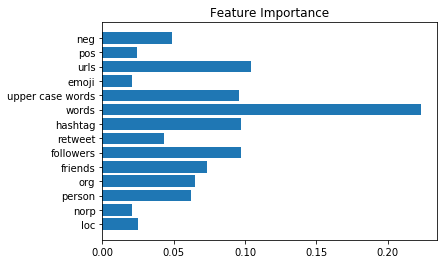

<Figure size 432x288 with 0 Axes>

In [52]:
plt.barh(list(dataset.columns)[:14], list(model.feature_importances_))
plt.title("Feature Importance")
plt.show()
plt.savefig("image/feature_importance.png", bbox_inches = 'tight')

### Categories label:

In [53]:
# convert categories into matrix.

# convert str to list.
cat_tr_list = []
cat_te_list = []

for i in tr_y[:, 0]:
    cat_tr_list.append(ast.literal_eval(i))
    
for i in te_y[:, 0]:
    cat_te_list.append(ast.literal_eval(i))

mlb_tr = MultiLabelBinarizer()
labels_tr = mlb_tr.fit_transform(cat_tr_list)
mlb_te = MultiLabelBinarizer()
labels_te = mlb_te.fit_transform(cat_te_list)

categories_tr = mlb_tr.classes_
categories_te = mlb_te.classes_

### Multi-label:

In [54]:
one_vs_rest = OneVsRestClassifier(LogisticRegression(class_weight="balanced", random_state=0, solver='lbfgs', max_iter=200), n_jobs=1)
preds_te_arr = np.zeros(labels_te.shape) 
accuracy = 0

for i, category in enumerate(categories_tr):
    
    one_vs_rest.fit(tr_X, labels_tr[:, i])
    preds_te = one_vs_rest.predict(te_X)
    preds_te_arr[:, i] = preds_te
    res = accuracy_score(labels_te[:, i], preds_te)
    print('Category:', category, ' F1-score:', f1_score(labels_te[:, i], preds_te), ' Accuracy: ', res)
    accuracy+=res

Category: Advice  F1-score: 0.14794921875  Accuracy:  0.5732974691282553
Category: CleanUp  F1-score: 0.02485875706214689  Accuracy:  0.6834576354077515
Category: ContextualInformation  F1-score: 0.07006020799124246  Accuracy:  0.5845457879936422
Category: Discussion  F1-score: 0.1959203036053131  Accuracy:  0.5855239026775889
Category: Donations  F1-score: 0.02432179607109448  Accuracy:  0.6174348942413498
Category: EmergingThreats  F1-score: 0.20190023752969122  Accuracy:  0.6713534661939112
Category: Factoid  F1-score: 0.23497636731937882  Accuracy:  0.5844235236581489
Category: FirstPartyObservation  F1-score: 0.05700712589073634  Accuracy:  0.5146105880914538
Category: GoodsServices  F1-score: 0.0045841519318926  Accuracy:  0.6283164201002568
Category: Hashtags  F1-score: 0.6804564907275321  Accuracy:  0.726127888494926
Category: InformationWanted  F1-score: 0.029411764705882353  Accuracy:  0.5642499083017484
Category: Irrelevant  F1-score: 0.42124542124542125  Accuracy:  0.536373

In [55]:
print('Accuracy all: ', accuracy/len(categories_tr))
print('F1-Score all: ', f1_score(labels_te,preds_te_arr,average='macro'))

Accuracy all:  0.6330847291844969
F1-Score all:  0.1778023001608622


### Feature Importance:

In [56]:
preds_te_arr = np.zeros(labels_te.shape) 
accuracy = 0
feature_list = []
for i, category in enumerate(categories_tr):
    
    model = GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=2020).fit(tr_X, labels_tr[:, i])
    preds_te = one_vs_rest.predict(te_X)
    preds_te_arr[:, i] = preds_te
    res = accuracy_score(labels_te[:, i], preds_te)
    temp = model.feature_importances_
    feature_list.append(temp)
    res = map(list(temp).index, heapq.nlargest(3, temp))
    cat = [list(dataset.columns)[:14][j] for j in res]
    print("Category: "+str(category), cat)

Category: Advice ['words', 'hashtag', 'followers']
Category: CleanUp ['words', 'friends', 'hashtag']
Category: ContextualInformation ['words', 'followers', 'hashtag']
Category: Discussion ['words', 'followers', 'hashtag']
Category: Donations ['words', 'followers', 'hashtag']
Category: EmergingThreats ['words', 'followers', 'upper case words']
Category: Factoid ['words', 'urls', 'neg']
Category: FirstPartyObservation ['words', 'hashtag', 'upper case words']
Category: GoodsServices ['words', 'hashtag', 'friends']
Category: Hashtags ['hashtag', 'words', 'followers']
Category: InformationWanted ['words', 'followers', 'hashtag']
Category: Irrelevant ['words', 'hashtag', 'urls']
Category: Location ['words', 'urls', 'hashtag']
Category: MovePeople ['words', 'hashtag', 'person']
Category: MultimediaShare ['urls', 'words', 'followers']
Category: NewSubEvent ['words', 'followers', 'hashtag']
Category: News ['words', 'urls', 'followers']
Category: Official ['words', 'followers', 'upper case words

Text(0.5, 1.0, 'multi-label feature importance')

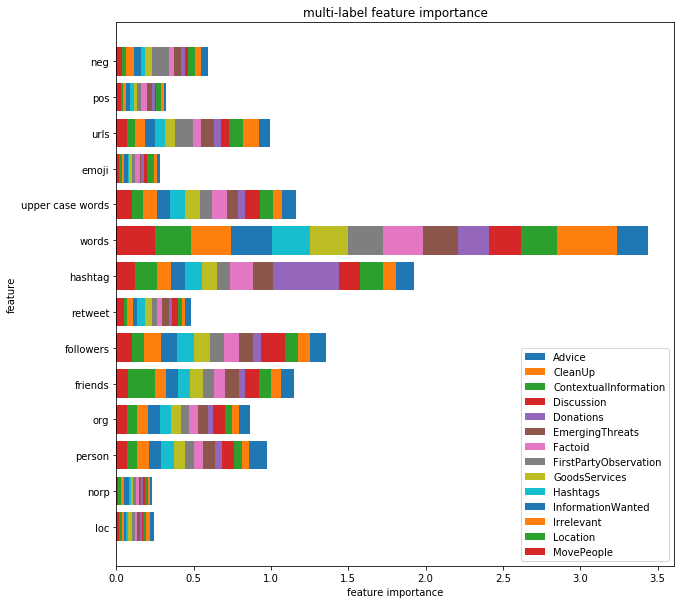

In [57]:
# %config InlineBackend.figure_format='svg'
plt.figure(figsize=(10, 10))
for i in range(14):
    plt.barh(list(dataset.columns)[:14], np.sum(feature_list[0:14-i], axis=0), label=categories_tr[i])
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.legend()
plt.title('multi-label feature importance')
# plt.savefig("image/featur")

### concatenate TF-IDF dataset and feature engineering dataset.

In [73]:
tr_final_X = np.concatenate((tr_X_1, tr_X),axis=1)
te_final_X = np.concatenate((te_X_1, te_X),axis=1)

# logistic regression.
filterwarnings('ignore')
clf = LogisticRegression(random_state=0, solver='saga', multi_class='auto', max_iter=300).fit(tr_final_X, tr_prior)
preds_te = clf.predict(te_final_X)

prob = clf.predict_proba(te_final_X)
score = 0

for i in range(len(te_prior)):
    if te_prior[i] == 0: weight = 1
    elif te_prior[i] == 1: weight = 0.25
    elif te_prior[i] == 2: weight = 0.5
    elif te_prior[i] == 3: weight = 0.75
    else: weight = 0

    score += (weight - prob[i, te_prior[i]] * weight)**2

score /= len(te_prior)

print("RMSE all: ", score)

RMSE all:  0.04555344565632896


In [74]:
one_vs_rest = OneVsRestClassifier(LogisticRegression(class_weight="balanced", random_state=0, solver='lbfgs', max_iter=300), n_jobs=1)
preds_te_arr = np.zeros(labels_te.shape) 
accuracy = 0

for i, category in enumerate(categories_tr):
    filterwarnings('ignore')
    one_vs_rest.fit(tr_final_X, labels_tr[:, i])
    preds_te = one_vs_rest.predict(te_final_X)
    preds_te_arr[:, i] = preds_te
    res = accuracy_score(labels_te[:, i], preds_te)
    print('Category:', category, ' F1-score:', f1_score(labels_te[:, i], preds_te), ' Accuracy: ', res)
    accuracy+=res
    
print('Accuracy all: ', accuracy/len(categories_tr))
print('F1-Score all: ', f1_score(labels_te,preds_te_arr,average='macro'))

Category: Advice  F1-score: 0.2330743618201998  Accuracy:  0.7465460325223132
Category: CleanUp  F1-score: 0.16170212765957445  Accuracy:  0.9759139259078127
Category: ContextualInformation  F1-score: 0.05078336034575906  Accuracy:  0.7851815625382076
Category: Discussion  F1-score: 0.16887944768985663  Accuracy:  0.6173126299058564
Category: Donations  F1-score: 0.24187725631768953  Accuracy:  0.9486489790927987
Category: EmergingThreats  F1-score: 0.2627737226277372  Accuracy:  0.8271182296124221
Category: Factoid  F1-score: 0.3182328715836765  Accuracy:  0.777356645066634
Category: FirstPartyObservation  F1-score: 0.14941948510853104  Accuracy:  0.5879691893874557
Category: GoodsServices  F1-score: 0.05617977528089887  Accuracy:  0.9589191832742389
Category: Hashtags  F1-score: 0.7107804750717828  Accuracy:  0.729062232546766
Category: InformationWanted  F1-score: 0.1056338028169014  Accuracy:  0.937889717569385
Category: Irrelevant  F1-score: 0.45687975916415796  Accuracy:  0.62501

### Decide weight:

In [76]:
# f1_score_list = [0.24589262507013984,
#  0.24589049241564193,
#  0.24585108250457516,
#  0.24579817388857625,
#  0.24568950879050508,
#  0.24568476029959954,
#  0.24575993754544775,
#  0.24584907936158643,
#  0.2455891589025643,
#  0.2457403734959275,
#  0.2457886122698053,
#  0.24582812220094688,
#  0.2456502954927343,
#  0.2456867640360486,
#  0.2458443536703795,
#  0.24564757857899708]

# f1_score_list = []
# for w in tqdm([1.5, 2, 2.5, 3]):
#     for f in [1, 2, 3, 4]:
#         weight = np.ones((1, 14))
#         if f == 1: weight[0, :4] = w
#         elif f == 2: weight[0, 4:7] = w
#         elif f ==3: weight[0, 7:-2] = w
#         else: weight[0, -2:] = w

## Ensemble learning: